In [1]:
import warnings
warnings.filterwarnings('ignore')

import librosa, librosa.display
import maad
import numpy as np
import pandas as pd
import os
from pathlib import Path
import sys
from datetime import datetime

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
from maad import sound, features
from maad.util import (date_parser, plot_correlation_map,
                       plot_features_map, plot_features, false_Color_Spectro)

SPECTRAL_FEATURES=[
    'MEANf','VARf','SKEWf','KURTf','NBPEAKS','LEQf',
'ENRf','BGNf','SNRf','Hf', 'EAS','ECU','ECV','EPS','EPS_KURT','EPS_SKEW',
                   'ACI',
'NDSI','rBA','AnthroEnergy','BioEnergy','BI','ROU','ADI','AEI',
    'LFC','MFC','HFC',
'ACTspFract','ACTspCount','ACTspMean', 'EVNspFract','EVNspMean','EVNspCount',
'TFSD','H_Havrda','H_Renyi','H_pairedShannon', 'H_gamma', 'H_GiniSimpson','RAOQ',
'AGI','ROItotal','ROIcover'
]

TEMPORAL_FEATURES=['ZCR','MEANt', 'VARt', 'SKEWt', 'KURTt',
               'LEQt','BGNt', 'SNRt','MED', 'Ht','ACTtFraction', 'ACTtCount',
               'ACTtMean','EVNtFraction', 'EVNtMean', 'EVNtCount']

In [3]:
def date_parser(datadir, extension ='.WAV', verbose=False):

    c_file = []
    c_date = []
    # find a file in subdirectories
    for root, subFolders, files in os.walk(datadir):
        for count, file in enumerate(files):
            if verbose: print(file)
            if extension.upper() in file or extension.lower() in file :
                filename = os.path.join(root, file)
                file_stem = Path(filename).stem
                c_file.append(filename)
                dd = datetime.strptime(file_stem, '%Y%m%d_%H%M%S') #audimoth
                print(dd)
                c_date.append(dd)

    ####### SORTED BY DATE
    # create a Pandas dataframe with date as index
    df = pd.DataFrame({'file':c_file, 'Date':c_date})
    # define Date as index
    df.set_index('Date', inplace=True)
    # sort dataframe by date
    df = df.sort_index(axis=0)
    return df

# df = date_parser("to_analyse/moth/", verbose=True)
df = date_parser("to_analyse/bugg/", verbose=True)

20220803_120904.wav
2022-08-03 12:09:04
.DS_Store
20220803_123416.wav
2022-08-03 12:34:16


In [148]:
df_indices = pd.DataFrame()
df_indices_per_bin = pd.DataFrame()

for index, row in df.iterrows() :

    # get the full filename of the corresponding row
    fullfilename = row['file']
    # Save file basename
    path, filename = os.path.split(fullfilename)
    print ('\n**************************************************************')
    print (filename)

    #### Load the original sound (16bits) and get the sampling frequency fs
    try :
        # wave,fs = sound.load(filename=fullfilename, channel='left', detrend=True, verbose=False)
        wave,fs = librosa.load(fullfilename, offset=0.0)
    except:
        # Delete the row if the file does not exist or raise a value error (i.e. no EOF)
        df.drop(index, inplace=True)
        continue

    """ =======================================================================
                     Computation in the time domain
    ========================================================================"""

    # Parameters of the audio recorder. This is not a mandatory but it allows
    # to compute the sound pressure level of the audio file (dB SPL) as a
    # sonometer would do.
    S = -35         # Sensbility microphone-35dBV (SM4) / -18dBV (Audiomoth)
    G = 26+16       # Amplification gain (26dB (SM4 preamplifier))
    """ASK ABOUT THE BUGG"""


    # compute all the audio indices and store them into a DataFrame
    # dB_threshold and rejectDuration are used to select audio events.
    df_audio_ind = features.all_temporal_alpha_indices(wave, fs,
                                          gain = G, sensibility = S,
                                          dB_threshold = 3, rejectDuration = 0.01,
                                          verbose = False, display = False)

    """ =======================================================================
                     Computation in the frequency domain
    ========================================================================"""

    # Compute the Power Spectrogram Density (PSD) : Sxx_power
    Sxx_power,tn,fn,ext = sound.spectrogram (wave, fs, window='hann',
                                             nperseg = 1024, noverlap=1024//2,
                                             verbose = False, display = False,
                                             savefig = None)

    # compute all the spectral indices and store them into a DataFrame
    # flim_low, flim_mid, flim_hi corresponds to the frequency limits in Hz
    # that are required to compute somes indices (i.e. NDSI)
    # if R_compatible is set to 'soundecology', then the output are similar to
    # soundecology R package.
    # mask_param1 and mask_param2 are two parameters to find the regions of
    # interest (ROIs). These parameters need to be adapted to the dataset in
    # order to select ROIs
    df_spec_ind, df_spec_ind_per_bin = features.all_spectral_alpha_indices(Sxx_power,
                                                            tn,fn,
                                                            flim_low = [0,1500],
                                                            flim_mid = [1500,8000],
                                                            flim_hi  = [8000,20000],
#                                                             ADJUST IF NEEDED
                                                            gain = G, sensitivity = S,
                                                            verbose = False,
                                                            R_compatible = 'soundecology',
                                                            mask_param1 = 6,
                                                            mask_param2=0.5,
                                                            display = False)

    """ =======================================================================
                     Create a dataframe
    ========================================================================"""
    # First, we create a dataframe from row that contains the date and the
    # full filename. This is done by creating a DataFrame from row (ie. TimeSeries)
    # then transposing the DataFrame.
    df_row = pd.DataFrame(row)
    df_row =df_row.T
    df_row.index.name = 'Date'
    df_row = df_row.reset_index()

    # add scalar indices into the df_indices dataframe
    df_indices = df_indices.append(pd.concat([df_row,
                                              df_audio_ind,
                                              df_spec_ind], axis=1))
    # add vector indices into the df_indices_per_bin dataframe
    df_indices_per_bin = df_indices_per_bin.append(pd.concat([df_row,
                                                              df_spec_ind_per_bin], axis=1))
# Set back Date as index
df_indices = df_indices.set_index('Date')
df_indices_per_bin = df_indices_per_bin.set_index('Date')


**************************************************************
20220803_120904.wav

**************************************************************
20220803_123416.wav


In [150]:
df_indices

,file,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,...,TFSD,H_Havrda,H_Renyi,H_pairedShannon,H_gamma,H_GiniSimpson,RAOQ,AGI,ROItotal,ROIcover
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-03 12:09:04,to_analyse/bugg/20220803_120904.wav,1927.507264,-0.000076,9.275667e-07,-0.746966,33.601947,32.721438,-56.321678,2.925897,0.001527,...,0.187833,0.320106,1.613420,3.299096,5702.558224,0.828479,0.060193,1.223849,523,1.728455
2022-08-03 12:34:16,to_analyse/bugg/20220803_123416.wav,1689.977541,-0.000076,1.354188e-06,-0.484028,18.588303,34.356017,-55.090298,3.407372,0.001760,...,0.146317,0.323921,1.783558,3.465174,4439.916697,0.858904,0.038153,1.227788,332,3.440886


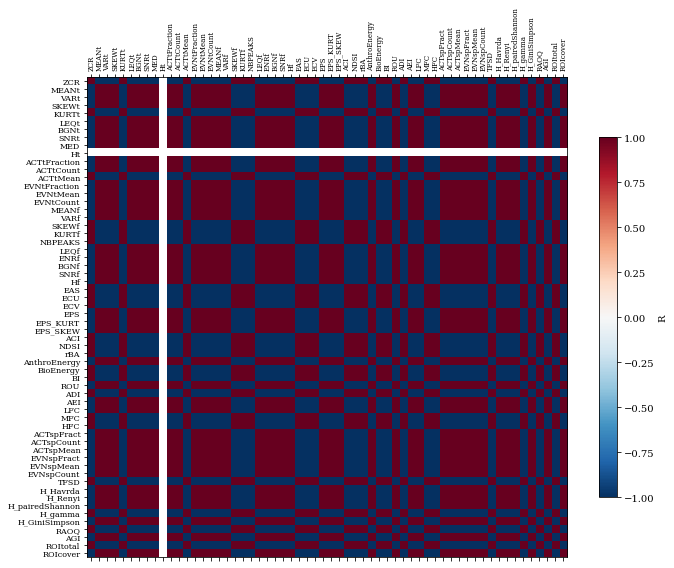

In [151]:
fig, ax = plot_correlation_map(df_indices, R_threshold=0)

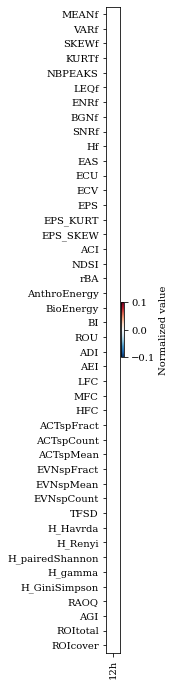

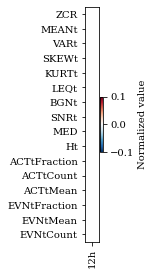

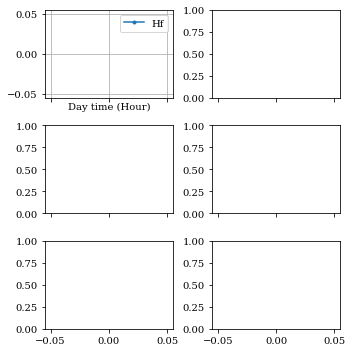

In [152]:
plot_features_map(df_indices[SPECTRAL_FEATURES], mode='24h')
plot_features_map(df_indices[TEMPORAL_FEATURES], mode='24h')

# A more classical way to analyse variations of indices consists in plotting
# graphs. We choose to normalize rescale their value between 0 to 1 in order to
# compare their trend during a 24h cycle
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,2, sharex=True, squeeze=True, figsize=(5,5))

fig, ax[0,0] = plot_features(df_indices[['Hf']],norm=True,mode='24h', ax=ax[0,0])
fig, ax[0,1] = plot_features(df_indices[['AEI']],norm=True,mode='24h', ax=ax[0,1])
fig, ax[1,0] = plot_features(df_indices[['NDSI']],norm=True,mode='24h', ax=ax[1,0])
fig, ax[1,1] = plot_features(df_indices[['ACI']],norm=True,mode='24h', ax=ax[1,1])
fig, ax[2,0] = plot_features(df_indices[['MED']],norm=True,mode='24h', ax=ax[2,0])
fig, ax[2,1] = plot_features(df_indices[['ROItotal']],norm=True,mode='24h', ax=ax[2,1])

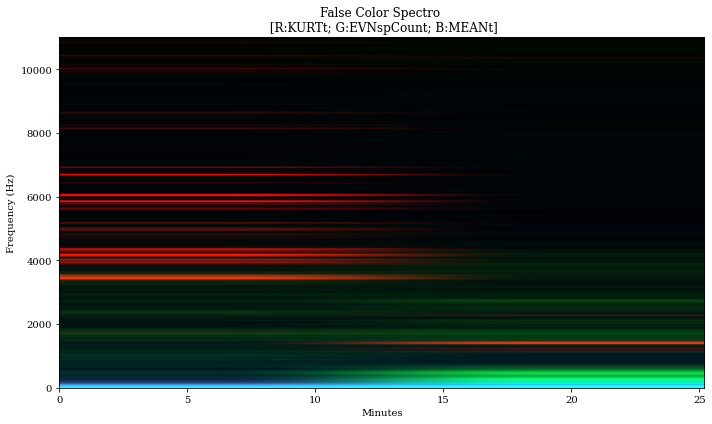

In [153]:
fcs, triplet = false_Color_Spectro(df_indices_per_bin,
                                   indices = ['KURTt_per_bin',
                                              'EVNspCount_per_bin',
                                              'MEANt_per_bin'],
                                   reverseLUT=False,
                                   unit='minutes',
                                   permut=False,
                                   display=True,
                                   figsize=(10,6))